In [1]:
import datetime
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt 

In [21]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("train.csv")

In [3]:
print("Size of Dataset:", df.shape)
print("Features:\n", list(df.columns))

Size of Dataset: (1023552, 44)
Features:
 ['Unnamed: 0', 'id', 'stmt_date', 'HQ_city', 'legal_struct', 'ateco_sector', 'def_date', 'fs_year', 'asst_intang_fixed', 'asst_tang_fixed', 'asst_fixed_fin', 'asst_current', 'AR', 'cash_and_equiv', 'asst_tot', 'eqty_tot', 'eqty_corp_family_tot', 'liab_lt', 'liab_lt_emp', 'debt_bank_st', 'debt_bank_lt', 'debt_fin_st', 'debt_fin_lt', 'AP_st', 'AP_lt', 'debt_st', 'debt_lt', 'rev_operating', 'COGS', 'prof_operations', 'goodwill', 'inc_financing', 'exp_financing', 'prof_financing', 'inc_extraord', 'taxes', 'profit', 'days_rec', 'ebitda', 'roa', 'roe', 'wc_net', 'margin_fin', 'cf_operations']


In [6]:
print('\n Unique default dates: ', df.def_date.unique(), '\n Unique fiscal years: ', df.fs_year.unique(), 
      '\n Unique statement dates: ', df.stmt_date.unique())


 Unique default dates:  ['NaT' '31/10/2008' '28/07/2008' ... '27/07/2013' '01/11/2013'
 '03/01/2013'] 
 Unique fiscal years:  [2011 2008 2009 2012 2007 2010] 
 Unique statement dates:  ['2011-12-31' '2008-12-31' '2009-12-31' '2012-12-31' '2007-12-31'
 '2010-12-31']


## Distribution of null values

In [7]:
df.isnull().sum() * 100 / len(df)

Unnamed: 0                0.000000
id                        0.000000
stmt_date                 0.000000
HQ_city                   0.027063
legal_struct              0.000000
ateco_sector              0.000000
def_date                  0.000000
fs_year                   0.000000
asst_intang_fixed         0.015827
asst_tang_fixed           0.010063
asst_fixed_fin            0.023155
asst_current              0.000098
AR                        0.001172
cash_and_equiv            0.001661
asst_tot                  0.000000
eqty_tot                  0.000098
eqty_corp_family_tot    100.000000
liab_lt                   0.028724
liab_lt_emp               0.015827
debt_bank_st             11.853917
debt_bank_lt              8.887775
debt_fin_st              11.994701
debt_fin_lt               8.994951
AP_st                    11.785918
AP_lt                     9.012146
debt_st                   0.000488
debt_lt                   0.015143
rev_operating             0.017000
COGS                

## Distribution of Legal Structure

<Axes: xlabel='legal_struct'>

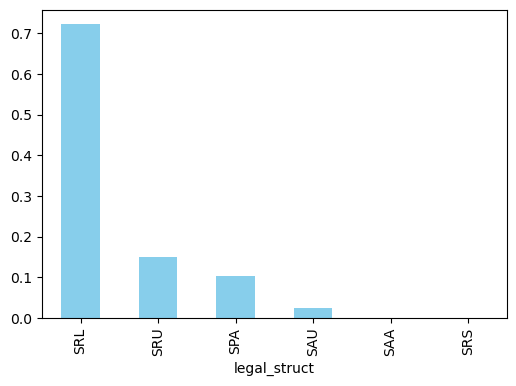

In [8]:
legal_struct_distribution = df['legal_struct'].value_counts(normalize=True)
plt.figure(figsize=(6, 4))
legal_struct_distribution.plot(kind='bar', color='skyblue')

## Distribution of Industry Sector

<Axes: xlabel='ateco_sector'>

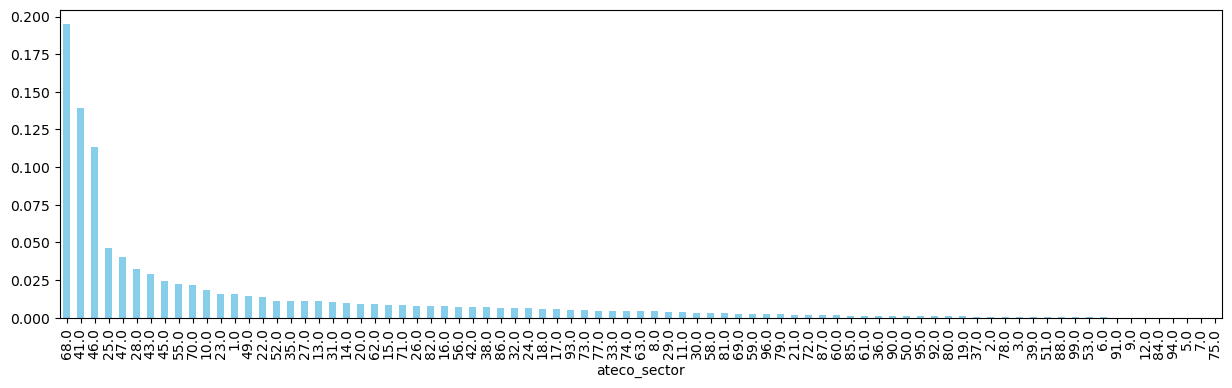

In [9]:
ateco_sector_distribution = df['ateco_sector'].value_counts(normalize=True)
plt.figure(figsize=(15, 4))
ateco_sector_distribution.plot(kind='bar', color='skyblue')

## Percentage of Firms with Taxes Liability

In [10]:
# Calculate average taxes and extraordinary income, then merge them into a single DataFrame
taxes = (
    df.groupby('id')[['taxes', 'inc_extraord']]
    .mean()
    .rename(columns={'taxes': 'avg_taxes', 'inc_extraord': 'avg_ext_inc'})
    .reset_index()
)

# Calculate the percentage of firms with and without tax liability
num_unique_firms = taxes['id'].nunique()
percent_no_tax_liability = (taxes['avg_taxes'] <= 0).mean() * 100
percent_with_tax_liability = (taxes['avg_taxes'] > 0).mean() * 100

# Print the results
print(f'% of unique firms with no tax liability: {percent_no_tax_liability:.2f}')
print(f'% of unique firms with tax liability: {percent_with_tax_liability:.2f}')

% of unique firms with no tax liability: 31.31
% of unique firms with tax liability: 68.69


## Percentage of Default vs. Non-Defaulted firms:


In [11]:
percent_default = np.round(((len(df[df['def_date'] != 'NaT']) / len(df)) * 100),2)

print("% Nondefault:", 100 - percent_default)
print("% Default:",  percent_default)

% Nondefault: 94.59
% Default: 5.41


## Distribution of Defaulted Firms in Each Year

In [12]:
defaulted = df[df['def_date'].notna()]
nondefaulted = df[df['def_date'].isna()]

# Convert 'def_date' to datetime and plot
sns.kdeplot(x=pd.to_datetime(defaulted['def_date'], errors='coerce'), data=defaulted)
plt.title("Distribution of Defaulted Firms")
plt.xlabel("Default Date")
plt.show()

/var/folders/96/qy4rp5xs53jg5bnrc23rsvl40000gn/T/ipykernel_33304/1229468837.py:5: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  sns.kdeplot(x=pd.to_datetime(defaulted['def_date'], errors='coerce'), data=defaulted)
/Users/catherine/anaconda3/envs/Env1/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/catherine/anaconda3/envs/Env1/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


## Fill Missing Values

In [13]:
df['roa'] = df['roa'].fillna(df['profit'] / df['asst_tot'])
df['exp_financing'] = df['exp_financing'].fillna(df['inc_financing'] - df['prof_financing'])
df['eqty_tot'] = df['eqty_tot'].fillna(df['asst_tot'] - (df['liab_lt'] + df['debt_bank_st'] + df['debt_bank_lt'] +
                                        df['debt_fin_st'] + df['debt_fin_lt'] + df['AP_st'] +
                                        df['AP_lt']))


## Feature Selection

Size: total asset 

Leverage: total debt / total asset = (total asset - total equity) / total asset

Profitability: ROA

Liquidity: cash & equivalents / total asset

Debt coverage: operating cash flow / financial expense


In [14]:
df['def_date'] = pd.to_datetime(df['def_date'], dayfirst=True)
df['stmt_date'] = pd.to_datetime(df['stmt_date'])
df['Leverage'] = (df['asst_tot'] - df['eqty_tot']) / df['asst_tot']
df['Liquidity'] = df['cash_and_equiv'] / (df['asst_tot'])
df['Debt_coverage'] = df['cf_operations'] / df['exp_financing']

In [15]:
train = df[['id', 'stmt_date', 'fs_year', 'def_date', 'legal_struct', 'ateco_sector', 
            'HQ_city', 'roa', 'Leverage', 'Debt_coverage', 'Liquidity', 'asst_tot']].copy()

# Rename columns for clarity
train.rename(columns={'roa': 'ROA', 'eqty_tot': 'Total_Asset'}, inplace=True)
train.head()

id  stmt_date  fs_year def_date legal_struct  ateco_sector  HQ_city  \
0  520288 2011-12-31     2011      NaT          SRL          14.0     28.0   
1  520288 2008-12-31     2008      NaT          SRL          14.0     28.0   
2  520288 2009-12-31     2009      NaT          SRL          14.0     28.0   
3  520288 2012-12-31     2012      NaT          SRL          14.0     28.0   
4  520288 2007-12-31     2007      NaT          SRL          14.0     28.0   

     ROA  Leverage  Debt_coverage  Liquidity   asst_tot  
0  -3.81  0.851058      -0.054598   0.001070  1946940.0  
1  -2.76  1.017968      -0.077998   0.002570  2077346.0  
2  -2.17  1.022845       0.925622   0.005310  1975874.0  
3 -12.99  0.979073     -12.015864   0.003496  1872882.0  
4   6.20  0.960398       5.898666   0.008071  1769122.0

## Correlation Between Features

In [16]:
train.iloc[: , -5:].describe()[1:].corr()


/Users/catherine/anaconda3/envs/Env1/lib/python3.11/site-packages/numpy/core/_methods.py:49: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


ROA  Leverage  Debt_coverage  Liquidity  asst_tot
ROA            1.000000  0.751749       0.954915   0.999054  0.744949
Leverage       0.751749  1.000000       0.863816   0.733694  0.999921
Debt_coverage  0.954915  0.863816       1.000000   0.999956  0.995023
Liquidity      0.999054  0.733694       0.999956   1.000000  0.726833
asst_tot       0.744949  0.999921       0.995023   0.726833  1.000000

## Check Multicollinearity: 

	VIF = 1: No multicollinearity (the variable is not correlated with other predictors).

	VIF between 1 and 5: Low to moderate multicollinearity (acceptable in most cases).

	VIF above 5: Moderate to high multicollinearity (might need closer examination, especially in sensitive models).

	VIF above 10: High multicollinearity (often considered problematic and typically indicates that you should consider removing or transforming the variable).

In [17]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Assuming `train` is your DataFrame containing the columns you want to check for multicollinearity
# Select only the numerical features for VIF calculation
features = train[['ROA', 'Leverage', 'Debt_coverage', 'Liquidity', 'asst_tot']]
features_cleaned = features.replace([np.inf, -np.inf], np.nan).dropna()

# Add a constant to the model for VIF calculation
X = add_constant(features_cleaned)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display the VIF data
print(vif_data)

         Feature       VIF
0          const  6.807850
1            ROA  1.069243
2       Leverage  1.044373
3  Debt_coverage  1.000584
4      Liquidity  1.047004
5       asst_tot  1.000183


#### Fiscal Years:

In [18]:
train['default_year'] = [date.year for date in pd.to_datetime(train['def_date'], format = "%d/%m/%Y")]
train['target'] = np.logical_and(train.default_year.notna(), train['fs_year'] + 1 >= train.default_year).astype(int)
train

id  stmt_date  fs_year def_date legal_struct  ateco_sector  \
0             520288 2011-12-31     2011      NaT          SRL          14.0   
1             520288 2008-12-31     2008      NaT          SRL          14.0   
2             520288 2009-12-31     2009      NaT          SRL          14.0   
3             520288 2012-12-31     2012      NaT          SRL          14.0   
4             520288 2007-12-31     2007      NaT          SRL          14.0   
...              ...        ...      ...      ...          ...           ...   
1023547  92001230520 2011-12-31     2011      NaT          SPA          93.0   
1023548  92001230520 2008-12-31     2008      NaT          SPA          93.0   
1023549  92001230520 2007-12-31     2007      NaT          SPA          93.0   
1023550  94111750108 2010-12-31     2010      NaT          SRL          68.0   
1023551  94111750108 2011-12-31     2011      NaT          SRL          68.0   

         HQ_city    ROA  Leverage  Debt_coverage  Liquidity   asst_tot  \
0           28.0  -3.81  0.851058      -0.054598   0.001070  1946940.0   
1           28.0  -2.76  1.017968      -0.077998   0.002570  2077346.0   
2           28.0  -2.17  1.022845       0.925622   0.005310  1975874.0   
3           28.0 -12.99  0.979073     -12.015864   0.003496  1872882.0   
4           28.0   6.20  0.960398       5.898666   0.008071  1769122.0   
...          ...    ...       ...            ...        ...        ...   
1023547     52.0   2.16  0.918389       6.999581   0.000081  7648851.0   
1023548     52.0  12.97  0.897331       4.469833   0.000023  6223862.0   
1023549     52.0   6.15  0.897084       8.157203   0.005630  6146110.0   
1023550     10.0  -0.31  0.832813           -inf   0.019239  1547771.0   
1023551     10.0  -0.85  0.821974   -4476.000000   0.150017  1504230.0   

         default_year  target  
0                 NaN       0  
1                 NaN       0  
2                 NaN       0  
3                 NaN       0  
4                 NaN       0  
...               ...     ...  
1023547           NaN       0  
1023548           NaN       0  
1023549           NaN       0  
1023550           NaN       0  
1023551           NaN       0  

[1023552 rows x 14 columns]

In [19]:
train.target.value_counts()

target
0    1012008
1      11544
Name: count, dtype: int64

## A Logit Model With Features

In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler

# Assuming 'df' is your DataFrame and it includes 'target' as the dependent variable
# Replace infinite values and drop rows with NaNs for training
train = train.replace([np.inf, -np.inf], np.nan).dropna()

# Define X and y
X = train[['ROA', 'Leverage', 'Debt_coverage', 'Liquidity', 'asst_tot']]
y = train['target']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Build and train the logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict probabilities for the test set
y_pred_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc_score = roc_auc_score(y_test, y_pred_proba)

# Calculate the AUC score
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"AUC Score: {auc_score:.4f}")

AUC Score: 0.7392


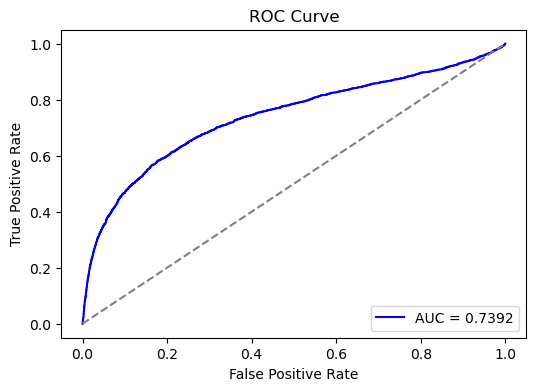

In [26]:
# Plotting the AUC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {auc_score:.4f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()